# 230711_anal_activations
230703_causal_tracing_visualisation 을 submodule로 바꾼것


# dict_causal_effects_230711 저장했으니깐 뒤로고고

# Import libraries

In [1]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast, GPT2Tokenizer, set_seed, GPT2LMHeadModel
from datasets import load_dataset
from tqdm import tqdm
import json
import torch
import datasets
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pylab as plt
from os import listdir

/rds/general/user/jj1122/home/anaconda3/envs/m2d2_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Config

In [2]:
torch.manual_seed(718)
set_seed(718)

In [3]:
# ROME
# - localisation: pre-trained LM을 대상으로 지식 정보가 담겨있는 모듈을 찾아냄
# - ROME: 해당 부분에 적합한 

# 내가 만들고 싶은 model editing은 fine-tuning을 대체할 수 있는 방법이었음

In [4]:
cache_dir="/rds/general/user/jj1122/ephemeral/.cache/huggingface"
output_dir = "/rds/general/user/jj1122/home/projects/m2d2/utils/output_logs/"

# cache_dir="/Users/joon/.cache/huggingface"
# output_dir = "/Users/joon/PycharmProjects/imperial/domain_adaptation_m2d2/output_logs/"


device_id = 'cpu'
# tuned_model_path = f"/rds/general/user/jj1122/home/projects/m2d2/dataset/{dataset_nm}/models"
# n_layers = 12
list_modules = ['attn', 'mlp']
# trace_module_id = "transformer.h.{l}.{m}"
list_gubun = ["omcd"]

# Data

## Dataset

In [5]:
df_dataset = pd.read_csv("./data/dataset_info_230709.tsv", sep="\t")

In [6]:
list_dataset_nms =df_dataset.loc[(df_dataset.category == "L1") & (df_dataset.editing == True), "dataset"].tolist() # TODO

## submodule

In [7]:
cache_dir = "/rds/general/user/jj1122/ephemeral/.cache/huggingface"

def parse_code_submodule(row):
    list_code = row.code.split(".")
    row["trace_id"] = ".".join(row["code"].split(".")[:-1])
#     row["component_id"] = ".".join(row["code"].split(".")[1:-1])
    is_in_layer = row["code"].startswith("transformer.h")
    

    if is_in_layer:        
        row["layer"] = int(list_code[2])
        row["module"] = list_code[3]
    else:
        row["module"] = list_code[1]
        if row["module"] == "ln_f": 
            row["layer"] = int(99)
        elif row["module"] in ["wte", "wpe"]:
            row['layer'] = int(-1)
    
    if row["module"] in ["attn", "mlp"]:
        row["submodule"] = list_code[-2]
    else:
        row["submodule"] = row["module"]

    row["w_or_b"] = list_code[-1]
    row["is_in_layer"] = is_in_layer
    
    is_investigated = (not row["code"].startswith("transformer.w")) and (not row["submodule"].startswith("ln"))
    row["is_investigated"] = is_investigated

    return row


dict_n_parmas = {tup[0]: tup[1].numel() for tup in GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to("cpu").named_parameters()}
df_submodule = pd.DataFrame.from_dict(dict_n_parmas, orient="index").reset_index()
df_submodule.columns = ["code", 'params']
df_submodule = df_submodule.apply(lambda row: parse_code_submodule(row), axis=1)
df_temp = df_submodule.groupby("trace_id")["params"].sum().to_frame().reset_index()
df_temp.columns = ["trace_id", "total"]

df_submodule["display_id"] = df_submodule["layer"].astype(str) + "." + df_submodule["module"]

df_submodule.loc[df_submodule.module != df_submodule.submodule, "display_id"] \
    = df_submodule.loc[df_submodule.module != df_submodule.submodule, "display_id"] \
        + "." + df_submodule.loc[df_submodule.module != df_submodule.submodule, "submodule"]

df_submodule = df_submodule.merge(df_temp, on=["trace_id"])
df_submodule.head()

code  is_in_layer  is_investigated  layer  \
0              transformer.wte.weight        False            False     -1   
1              transformer.wpe.weight        False            False     -1   
2         transformer.h.0.ln_1.weight         True            False      0   
3           transformer.h.0.ln_1.bias         True            False      0   
4  transformer.h.0.attn.c_attn.weight         True             True      0   

  module    params submodule                     trace_id  w_or_b  \
0    wte  38597376       wte              transformer.wte  weight   
1    wpe    786432       wpe              transformer.wpe  weight   
2   ln_1       768      ln_1         transformer.h.0.ln_1  weight   
3   ln_1       768      ln_1         transformer.h.0.ln_1    bias   
4   attn   1769472    c_attn  transformer.h.0.attn.c_attn  weight   

      display_id     total  
0         -1.wte  38597376  
1         -1.wpe    786432  
2         0.ln_1      1536  
3         0.ln_1      1536  
4  0.attn.c_attn   1771776

In [8]:
list_trace_module_ids = df_submodule.loc[df_submodule.is_investigated, "trace_id"].unique().tolist()
print(list_trace_module_ids[:3])

['transformer.h.0.attn.c_attn', 'transformer.h.0.attn.c_proj', 'transformer.h.0.mlp.c_fc']


In [ ]:
# list_trace_module_ids = df_submodule

# for l in range(n_layers):
#     for m in list_modules:
#         list_trace_module_ids.append(trace_module_id.format(l=l, m=m))

# print(list_trace_module_ids[:3])

In [ ]:
# def get_json_path(dir_path, ds_nm):
#     l_dir = listdir(dir_path)
#     dt = max([x.split("_")[0] for x in l_dir if x.endswith(f"_{ds_nm}.json") and "_sub_" not in x])
#     return dir_path + f"{dt}_{ds_nm}.json"

## Model Config

In [38]:
def get_json_path(dir_path, ds_nm):
    l_dir = listdir(dir_path)
    dt = max([x.split("_")[0] for x in l_dir if x.endswith(f"_{ds_nm}.json") and "_sub_" in x])
    return dir_path + f"{dt}_sub_{ds_nm}.json"

dict_causal_effects = {k: {} for k in list_dataset_nms}

for ds_nm in list_dataset_nms:
    print(ds_nm)
    for gubun in list_gubun:
        dict_causal_effects[ds_nm][gubun] = {}
        file_path = get_json_path(output_dir, f"{gubun}_{ds_nm}")
        with open(file_path, "r") as json_file:
            dict_causal_effects[ds_nm][gubun]["differences"] = json.load(json_file)
            dict_causal_effects[ds_nm][gubun]["path"] = file_path
            dict_causal_effects[ds_nm][gubun]["total"] = len(dict_causal_effects[ds_nm][gubun]["differences"])
            dict_causal_effects[ds_nm][gubun]["sents"] = len([x for x in dict_causal_effects[ds_nm][gubun]["differences"] if len(x) > 0])
            print("{gubun}: {sents} / {total} / {is_same} / {file_path}".format(
                gubun=gubun, sents=dict_causal_effects[ds_nm][gubun]["sents"], total=dict_causal_effects[ds_nm][gubun]["total"],
                is_same=dict_causal_effects[ds_nm][gubun]["total"] == dict_causal_effects[ds_nm][gubun]["sents"],
                file_path=file_path
            ))

Religion_and_belief_systems
omcd: 88417 / 88417 / True / /rds/general/user/jj1122/home/projects/m2d2/utils/output_logs/230708_sub_omcd_Religion_and_belief_systems.json
nlin_l1
omcd: 25402 / 25402 / True / /rds/general/user/jj1122/home/projects/m2d2/utils/output_logs/230708_sub_omcd_nlin_l1.json
Health_and_fitness
omcd: 121243 / 121243 / True / /rds/general/user/jj1122/home/projects/m2d2/utils/output_logs/230708_sub_omcd_Health_and_fitness.json
econ_l1
omcd: 14559 / 14559 / True / /rds/general/user/jj1122/home/projects/m2d2/utils/output_logs/230709_sub_omcd_econ_l1.json
Natural_and_physical_sciences
omcd: 271000 / 306689 / False / /rds/general/user/jj1122/home/projects/m2d2/utils/output_logs/230708_sub_omcd_Natural_and_physical_sciences.json
stat_l1
omcd: 13218 / 13218 / True / /rds/general/user/jj1122/home/projects/m2d2/utils/output_logs/230708_sub_omcd_stat_l1.json
History_and_events
omcd: 177991 / 177991 / True / /rds/general/user/jj1122/home/projects/m2d2/utils/output_logs/230708_su

In [40]:
dict_causal_effects["Natural_and_physical_sciences"]["omcd"]["differences"] = dict_causal_effects["Natural_and_physical_sciences"]["omcd"]["differences"][:271000]

In [45]:
for ds_nm, d_value in dict_causal_effects.items():
    print(ds_nm)
#     if ds_nm in ["cs_l1", "nlin_l1", "Health_and_fitness", "Natural_and_physical_sciences", "Religion_and_belief_systems"]: 
#         continue
    
    for gubun in list_gubun:
        list_differences = d_value[gubun]["differences"]
        list_df_temp = list(range(len(list_differences)))
        
        for i, d in enumerate(list_differences):
        #     print(i)
#             TE = (d["corrupted_loss"] - d["clean_loss"]) / d["clean_loss"]
            TE = -(d['clean_loss'] - d["corrupted_loss"])
            IE_original = {}
            IE = {}
            
            for m_id in list_trace_module_ids:
                IE_original[m_id] = -(d["restored_loss"][m_id] - d["corrupted_loss"])
                IE[m_id] = IE_original[m_id] / TE
            list_df_temp[i] = pd.DataFrame.from_dict(IE, orient="index").reset_index()
            list_df_temp[i].columns = ["trace_id", f"{gubun}_IE"]
            list_df_temp[i][f"{gubun}_IE_original"] = list(IE_original.values())
            list_df_temp[i][f"{gubun}_TE"] = TE
            list_df_temp[i][f"{gubun}_clean_loss"] = d["clean_loss"]
            list_df_temp[i][f"{gubun}_corrupted_loss"] = d["corrupted_loss"]
            list_df_temp[i][f"{gubun}_restored_loss"] = [d["restored_loss"][m_id] for m_id in list_trace_module_ids]
            list_df_temp[i]["sent_id"] = i
            list_df_temp[i]["dataset"] = ds_nm
            
            del TE, IE
        
        df = pd.concat(list_df_temp, axis=0, ignore_index=True).reset_index(drop=True)
        df_submodule
        df["list_code"] = df["trace_id"].apply(lambda code: code.split("."))
        df["layer"] = df["list_code"].apply(lambda l: int(l[2]))
        df["module"] = df["list_code"].apply(lambda l: l[3])
        del list_df_temp, df["list_code"]

        d_value[gubun]["df"] = df
        d_value[gubun]["df_agg"] = df.groupby(["dataset", "trace_id", "layer", "module"]).agg({f"{gubun}_IE": ['mean', 'std']})

# TE = d["corrupted_loss"]-d['clean_loss']
# IE = [(d["corrupted_loss"] - restored_loss) / TE for restored_loss in d["restored_loss"].values()]

Religion_and_belief_systems
nlin_l1
Health_and_fitness
econ_l1
Natural_and_physical_sciences
stat_l1
History_and_events
q-bio_l1


In [46]:
# import pickle as pkl
# with open("dict_causal_effects_230711.pkl", "wb") as pkl_file:
#     pkl.dump(dict_causal_effects, pkl_file)

In [53]:
dict_causal_effects["Religion_and_belief_systems"]['']

{'omcd': {'differences': [{'clean_loss': 63.91878399603464,
    'corrupted_loss': 86.01081280546664,
    'restored_loss': {'transformer.h.0.ln_1': 82.59837611854934,
     'transformer.h.0.attn.c_attn': 82.59837611854934,
     'transformer.h.0.attn.c_proj': 82.59837611854934,
     'transformer.h.0.ln_2': 71.82868335876462,
     'transformer.h.0.mlp.c_fc': 71.82868335876462,
     'transformer.h.0.mlp.c_proj': 71.82868335876462,
     'transformer.h.1.ln_1': 77.1474390467044,
     'transformer.h.1.attn.c_attn': 77.1474390467044,
     'transformer.h.1.attn.c_proj': 77.1474390467044,
     'transformer.h.1.ln_2': 127.21033334723472,
     'transformer.h.1.mlp.c_fc': 127.21033334723472,
     'transformer.h.1.mlp.c_proj': 127.21033334723472,
     'transformer.h.2.ln_1': 78.96134849673851,
     'transformer.h.2.attn.c_attn': 78.96134849673851,
     'transformer.h.2.attn.c_proj': 78.96134849673851,
     'transformer.h.2.ln_2': 99.78537422280593,
     'transformer.h.2.mlp.c_fc': 99.78537422280593,


## Visualisation

In [9]:
import pickle as pkl
with open("dict_causal_effects_230711.pkl", "rb") as pkl_file:
    dict_causal_effects = pkl.load(pkl_file)

In [39]:
list_omcd_temp = []
# list_tmod_temp = []
for ds_nm in dict_causal_effects.keys():
    list_omcd_temp.append(dict_causal_effects[ds_nm]["omcd"]["df_agg"][:])
    list_omcd_temp[-1].loc[:, "source"] = "s2orc" if ds_nm.endswith("l1") else "wiki"
#     list_tmod_temp.append(dict_causal_effects[ds_nm]["tmod"]["df_agg"][:])
#     list_tmod_temp[-1].loc[:, "dataset"] = ds_nm
#     list_tmod_temp[-1].loc[:, "source"] = "s2orc" if ds_nm.endswith("l1") else "wiki"
    
df_omcd = pd.concat(list_omcd_temp).reset_index().drop("module", axis=1)
# df_tmod = pd.concat(list_tmod_temp).reset_index()

del list_omcd_temp 

/var/tmp/pbs.7910293.pbs/ipykernel_2336102/4081734407.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_omcd_temp[-1].loc[:, "source"] = "s2orc" if ds_nm.endswith("l1") else "wiki"
/var/tmp/pbs.7910293.pbs/ipykernel_2336102/4081734407.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  list_omcd_temp[-1].loc[:, "source"] = "s2orc" if ds_nm.endswith("l1") else "wiki"
/var/tmp/pbs.7910293.pbs/ipykernel_2336102/4081734407.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [44]:
df_omcd

dataset                     trace_id layer   omcd_IE  \
                                                                         mean   
0    Religion_and_belief_systems  transformer.h.0.attn.c_attn     0 -1.635724   
1    Religion_and_belief_systems  transformer.h.0.attn.c_proj     0 -1.635724   
2    Religion_and_belief_systems     transformer.h.0.mlp.c_fc     0 -0.688651   
3    Religion_and_belief_systems   transformer.h.0.mlp.c_proj     0 -0.688651   
4    Religion_and_belief_systems  transformer.h.1.attn.c_attn     1 -0.500709   
..                           ...                          ...   ...       ...   
379                     q-bio_l1   transformer.h.8.mlp.c_proj     8  0.415089   
380                     q-bio_l1  transformer.h.9.attn.c_attn     9  0.324811   
381                     q-bio_l1  transformer.h.9.attn.c_proj     9  0.324811   
382                     q-bio_l1     transformer.h.9.mlp.c_fc     9  0.435531   
383                     q-bio_l1   transformer.h.9.mlp.c_proj     9  0.435531   

                source  
            std         
0    690.329592   wiki  
1    690.329592   wiki  
2    475.728793   wiki  
3    475.728793   wiki  
4     94.632910   wiki  
..          ...    ...  
379    2.190827  s2orc  
380    0.559709  s2orc  
381    0.559709  s2orc  
382    2.150064  s2orc  
383    2.150064  s2orc  

[384 rows x 6 columns]

In [45]:
df_omcd.columns = ["dataset", "trace_id", "layer", "IE_mean", "IE_std", "source"]
df_omcd = df_omcd.merge(df_submodule[["trace_id", "display_id"]].drop_duplicates(), on=["trace_id"])
df_omcd
df_omcd["IE_ranking"] = df_omcd.groupby(["dataset"])["IE_mean"].rank(ascending=False)


dataset                     trace_id  layer  \
0      Religion_and_belief_systems  transformer.h.0.attn.c_attn      0   
1                          nlin_l1  transformer.h.0.attn.c_attn      0   
2               Health_and_fitness  transformer.h.0.attn.c_attn      0   
3                          econ_l1  transformer.h.0.attn.c_attn      0   
4    Natural_and_physical_sciences  transformer.h.0.attn.c_attn      0   
..                             ...                          ...    ...   
379                        econ_l1   transformer.h.9.mlp.c_proj      9   
380  Natural_and_physical_sciences   transformer.h.9.mlp.c_proj      9   
381                        stat_l1   transformer.h.9.mlp.c_proj      9   
382             History_and_events   transformer.h.9.mlp.c_proj      9   
383                       q-bio_l1   transformer.h.9.mlp.c_proj      9   

      IE_mean      IE_std source     display_id  
0   -1.635724  690.329592   wiki  0.attn.c_attn  
1    0.874946   28.501713  s2orc  0.attn.c_attn  
2    0.493523   27.871300   wiki  0.attn.c_attn  
3    0.720032   10.169092  s2orc  0.attn.c_attn  
4    0.649735   36.399824   wiki  0.attn.c_attn  
..        ...         ...    ...            ...  
379  0.463977    6.440630  s2orc   9.mlp.c_proj  
380  0.438864   34.312359   wiki   9.mlp.c_proj  
381  0.435996    3.330682  s2orc   9.mlp.c_proj  
382  0.747112  153.438263   wiki   9.mlp.c_proj  
383  0.435531    2.150064  s2orc   9.mlp.c_proj  

[384 rows x 7 columns]

In [50]:
df_omcd.loc[df_omcd.dataset == 'nlin_l1']

dataset                      trace_id  layer   IE_mean      IE_std  \
1    nlin_l1   transformer.h.0.attn.c_attn      0  0.874946   28.501713   
9    nlin_l1   transformer.h.0.attn.c_proj      0  0.874946   28.501713   
17   nlin_l1      transformer.h.0.mlp.c_fc      0  0.770734   29.083899   
25   nlin_l1    transformer.h.0.mlp.c_proj      0  0.770734   29.083899   
33   nlin_l1   transformer.h.1.attn.c_attn      1  0.579665   81.935097   
41   nlin_l1   transformer.h.1.attn.c_proj      1  0.579665   81.935097   
49   nlin_l1      transformer.h.1.mlp.c_fc      1  0.490986   54.158896   
57   nlin_l1    transformer.h.1.mlp.c_proj      1  0.490986   54.158896   
65   nlin_l1  transformer.h.10.attn.c_attn     10  0.147766    7.183568   
73   nlin_l1  transformer.h.10.attn.c_proj     10  0.147766    7.183568   
81   nlin_l1     transformer.h.10.mlp.c_fc     10  0.543181   22.445098   
89   nlin_l1   transformer.h.10.mlp.c_proj     10  0.543181   22.445098   
97   nlin_l1  transformer.h.11.attn.c_attn     11  0.216839   18.909945   
105  nlin_l1  transformer.h.11.attn.c_proj     11  0.216839   18.909945   
113  nlin_l1     transformer.h.11.mlp.c_fc     11 -0.600402   92.521784   
121  nlin_l1   transformer.h.11.mlp.c_proj     11 -0.600402   92.521784   
129  nlin_l1   transformer.h.2.attn.c_attn      2  0.078014   23.879961   
137  nlin_l1   transformer.h.2.attn.c_proj      2  0.078014   23.879961   
145  nlin_l1      transformer.h.2.mlp.c_fc      2  0.595399   56.985847   
153  nlin_l1    transformer.h.2.mlp.c_proj      2  0.595399   56.985847   
161  nlin_l1   transformer.h.3.attn.c_attn      3 -0.357100   87.976726   
169  nlin_l1   transformer.h.3.attn.c_proj      3 -0.357100   87.976726   
177  nlin_l1      transformer.h.3.mlp.c_fc      3  0.554084   25.608456   
185  nlin_l1    transformer.h.3.mlp.c_proj      3  0.554084   25.608456   
193  nlin_l1   transformer.h.4.attn.c_attn      4  0.098867   30.292872   
201  nlin_l1   transformer.h.4.attn.c_proj      4  0.098867   30.292872   
209  nlin_l1      transformer.h.4.mlp.c_fc      4  1.582862  193.074493   
217  nlin_l1    transformer.h.4.mlp.c_proj      4  1.582862  193.074493   
225  nlin_l1   transformer.h.5.attn.c_attn      5  0.665594   46.795847   
233  nlin_l1   transformer.h.5.attn.c_proj      5  0.665594   46.795847   
241  nlin_l1      transformer.h.5.mlp.c_fc      5  0.756617   67.706373   
249  nlin_l1    transformer.h.5.mlp.c_proj      5  0.756617   67.706373   
257  nlin_l1   transformer.h.6.attn.c_attn      6  0.274589    6.161682   
265  nlin_l1   transformer.h.6.attn.c_proj      6  0.274589    6.161682   
273  nlin_l1      transformer.h.6.mlp.c_fc      6  0.283585   29.526629   
281  nlin_l1    transformer.h.6.mlp.c_proj      6  0.283585   29.526629   
289  nlin_l1   transformer.h.7.attn.c_attn      7  0.339786   14.457090   
297  nlin_l1   transformer.h.7.attn.c_proj      7  0.339786   14.457090   
305  nlin_l1      transformer.h.7.mlp.c_fc      7  0.250043   14.543565   
313  nlin_l1    transformer.h.7.mlp.c_proj      7  0.250043   14.543565   
321  nlin_l1   transformer.h.8.attn.c_attn      8  0.149797   18.332852   
329  nlin_l1   transformer.h.8.attn.c_proj      8  0.149797   18.332852   
337  nlin_l1      transformer.h.8.mlp.c_fc      8  0.004538   46.544109   
345  nlin_l1    transformer.h.8.mlp.c_proj      8  0.004538   46.544109   
353  nlin_l1   transformer.h.9.attn.c_attn      9  0.150713    7.352537   
361  nlin_l1   transformer.h.9.attn.c_proj      9  0.150713    7.352537   
369  nlin_l1      transformer.h.9.mlp.c_fc      9  0.354058    8.217950   
377  nlin_l1    transformer.h.9.mlp.c_proj      9  0.354058    8.217950   

    source      display_id  IE_ranking  
1    s2orc   0.attn.c_attn         3.5  
9    s2orc   0.attn.c_proj         3.5  
17   s2orc      0.mlp.c_fc         5.5  
25   s2orc    0.mlp.c_proj         5.5  
33   s2orc   1.attn.c_attn        13.5  
41   s2orc   1.attn.c_proj        13.5  
49   s2orc      1.mlp.c_fc        19.5  
5

In [46]:

df_omcd_agg = df_omcd.groupby(["display_id"])\
    .agg({"IE_ranking": ["mean", "std"], "IE_mean": ["mean", "std"]})
df_omcd_agg.columns = ["in_ranking_mean", "in_ranking_std", "all_mean", "all_std"]
df_omcd_agg["all_ranking"] = df_omcd_agg["all_mean"].rank(ascending=False)

In [34]:
df_omcd_agg[["all_ranking", "in_ranking_mean"]].sort_values("all_ranking").corr(method="kendall")

all_ranking  in_ranking_mean
all_ranking         1.000000         0.712732
in_ranking_mean     0.712732         1.000000

In [15]:
df_omcd_agg[["all_ranking", "in_ranking_mean"]].sort_values("all_ranking").corr()

all_ranking  in_ranking_mean
all_ranking         1.000000         0.875046
in_ranking_mean     0.875046         1.000000

In [28]:
df_omcd

dataset                     trace_id  layer module  \
0    Religion_and_belief_systems  transformer.h.0.attn.c_attn      0   attn   
1    Religion_and_belief_systems  transformer.h.0.attn.c_proj      0   attn   
2    Religion_and_belief_systems     transformer.h.0.mlp.c_fc      0    mlp   
3    Religion_and_belief_systems   transformer.h.0.mlp.c_proj      0    mlp   
4    Religion_and_belief_systems  transformer.h.1.attn.c_attn      1   attn   
..                           ...                          ...    ...    ...   
379                     q-bio_l1   transformer.h.8.mlp.c_proj      8    mlp   
380                     q-bio_l1  transformer.h.9.attn.c_attn      9   attn   
381                     q-bio_l1  transformer.h.9.attn.c_proj      9   attn   
382                     q-bio_l1     transformer.h.9.mlp.c_fc      9    mlp   
383                     q-bio_l1   transformer.h.9.mlp.c_proj      9    mlp   

      IE_mean      IE_std source  IE_ranking  
0   -1.635724  690.329592   wiki        47.5  
1   -1.635724  690.329592   wiki        47.5  
2   -0.688651  475.728793   wiki        41.5  
3   -0.688651  475.728793   wiki        41.5  
4   -0.500709   94.632910   wiki        39.5  
..        ...         ...    ...         ...  
379  0.415089    2.190827  s2orc         9.5  
380  0.324811    0.559709  s2orc        31.5  
381  0.324811    0.559709  s2orc        31.5  
382  0.435531    2.150064  s2orc         7.5  
383  0.435531    2.150064  s2orc         7.5  

[384 rows x 8 columns]

In [68]:
# df_tmod.columns = ["layer", "module", "IE_mean", "IE_std", "dataset", "source"]
# df_tmod["IE_ranking"] = df_tmod.groupby("dataset")["IE_mean"].rank(ascending=False)

# df_tmod_agg = df_tmod.groupby(["layer", "module"])\
#     .agg({"IE_ranking": ["mean", "std"], "IE_mean": ["mean", "std"]})
# df_tmod_agg.columns = ["in_ranking_mean", "in_ranking_std", "all_mean", "all_std"]
# df_tmod_agg["all_ranking"] = df_tmod_agg["all_mean"].rank(ascending=False)

In [69]:
# df_tmod_agg[["all_ranking", "in_ranking_mean"]].sort_values("all_ranking").corr(method="kendall")

In [70]:
# df_tmod_agg[["all_ranking", "in_ranking_mean"]].sort_values("all_ranking").corr()

In [71]:
# df_omcd = df_omcd.reset_index()

In [19]:
# df_cs_l1_omcd = dict_causal_effects["stat_l1"]["omcd"]["df"][:]
# df_cs_l1_omcd["cate_omcd_IE"] = pd.qcut(df_cs_l1_omcd["omcd_IE"], 10000)
# df_cs_l1_omcd["cate_omcd_IE"].value_counts().sort_index()

In [20]:
# df_cs_l1_omcd["cate_omcd_IE"].value_counts().sort_index().head(20)

In [21]:
# df_cs_l1_omcd["cate_omcd_IE"].value_counts().sort_index().tail(20)

In [22]:
# df_cs_l1_omcd.loc[~(df_cs_l1_omcd["omcd_IE"].between(-1, 1))]

In [27]:
dict_causal_effects[ds_nm]["omcd"]["df_agg"].drop([("omcd_IE", "std")], axis=1)

omcd_IE
                                                        mean
dataset  trace_id                     layer module          
q-bio_l1 transformer.h.0.attn.c_attn  0     attn    0.741846
         transformer.h.0.attn.c_proj  0     attn    0.741846
         transformer.h.0.mlp.c_fc     0     mlp     0.968934
         transformer.h.0.mlp.c_proj   0     mlp     0.968934
         transformer.h.1.attn.c_attn  1     attn   -0.742037
         transformer.h.1.attn.c_proj  1     attn   -0.742037
         transformer.h.1.mlp.c_fc     1     mlp     0.454208
         transformer.h.1.mlp.c_proj   1     mlp     0.454208
         transformer.h.10.attn.c_attn 10    attn    0.279184
         transformer.h.10.attn.c_proj 10    attn    0.279184
         transformer.h.10.mlp.c_fc    10    mlp     0.359710
         transformer.h.10.mlp.c_proj  10    mlp     0.359710
         transformer.h.11.attn.c_attn 11    attn    0.182899
         transformer.h.11.attn.c_proj 11    attn    0.182899
         transformer.h.11.mlp.c_fc    11    mlp    -0.021303
         transformer.h.11.mlp.c_proj  11    mlp    -0.021303
         transformer.h.2.attn.c_attn  2     attn    0.231662
         transformer.h.2.attn.c_proj  2     attn    0.231662
         transformer.h.2.mlp.c_fc     2     mlp     0.373505
         transformer.h.2.mlp.c_proj   2     mlp     0.373505
         transformer.h.3.attn.c_attn  3     attn    0.328441
         transformer.h.3.attn.c_proj  3     attn    0.328441
         transformer.h.3.mlp.c_fc     3     mlp     0.401131
         transformer.h.3.mlp.c_proj   3     mlp     0.401131
         transformer.h.4.attn.c_attn  4     attn    0.271261
         transformer.h.4.attn.c_proj  4     attn    0.271261
         transformer.h.4.mlp.c_fc     4     mlp     0.369687
         transformer.h.4.mlp.c_proj   4     mlp     0.369687
         transformer.h.5.attn.c_attn  5     attn    0.337614
         transformer.h.5.attn.c_proj  5     attn    0.337614
         transformer.h.5.mlp.c_fc     5     mlp     0.241424
         transformer.h.5.mlp.c_proj   5     mlp     0.241424
         transformer.h.6.attn.c_attn  6     attn    0.359233
         transformer.h.6.attn.c_proj  6     attn    0.359233
         transformer.h.6.mlp.c_fc     6     mlp     0.289054
         transformer.h.6.mlp.c_proj   6     mlp     0.289054
         transformer.h.7.attn.c_attn  7     attn    0.398518
         transformer.h.7.attn.c_proj  7     attn    0.398518
         transformer.h.7.mlp.c_fc     7     mlp     0.353757
         transformer.h.7.mlp.c_proj   7     mlp     0.353757
         transformer.h.8.attn.c_attn  8     attn    0.361942
         transformer.h.8.attn.c_proj  8     attn    0.361942
         transformer.h.8.mlp.c_fc     8     mlp     0.415089
         transformer.h.8.mlp.c_proj   8     mlp     0.415089
         transformer.h.9.attn.c_attn  9     attn    0.324811
         transformer.h.9.attn.c_proj  9     attn    0.324811
         transformer.h.9.mlp.c_fc     9     mlp     0.435531
         transformer.h.9.mlp.c_proj   9     mlp     0.435531

### Mean

- Visualisation 결과를 볼 수 있어야 함 -> 노답임
- 다음 norm 버전으로도 비교 -> 이제 해야함

<Axes: xlabel='dataset-trace_id-layer', ylabel='None-None-module'>

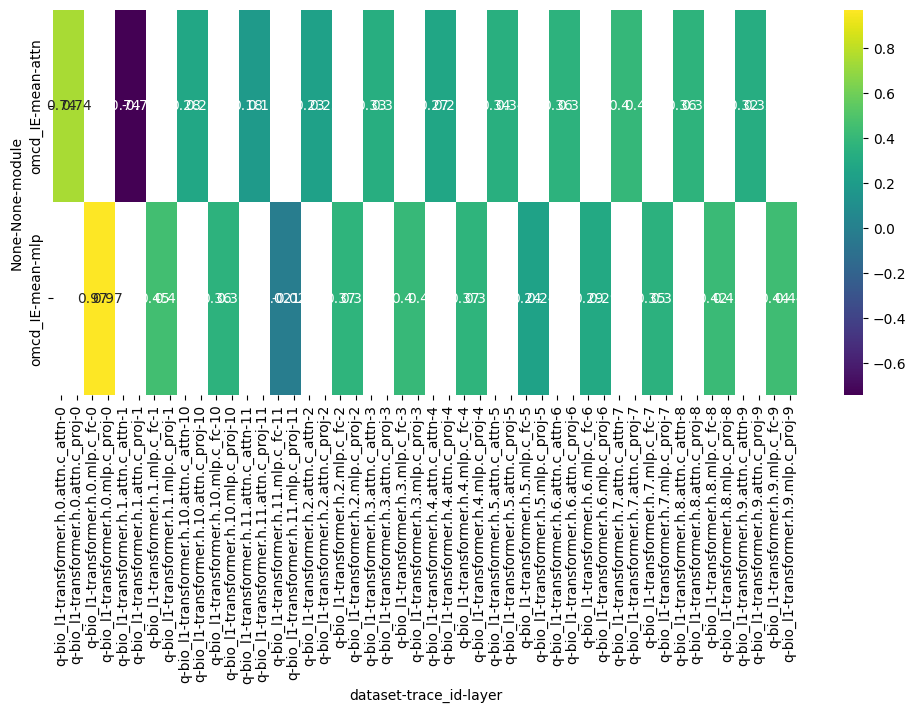

In [24]:
plt.rcParams["figure.figsize"] = (12,5)

sns.heatmap(
    pd.concat(
        [dict_causal_effects[ds_nm]["omcd"]["df_agg"].drop([("omcd_IE", "std")], axis=1).unstack(-1).T],
        axis=0#, ignore_index=True
    ),
    cmap = 'viridis', annot=True
)

In [81]:
plt.rcParams["figure.figsize"] = (12,5)
for idx, ds_nm in enumerate(list_dataset_nms):    
    idx = str(idx).zfill(2)
    img = sns.heatmap(
        pd.concat(
            [dict_causal_effects[ds_nm]["omcd"]["df_agg"].drop([("omcd_IE", "std")], axis=1).unstack(-1).T],
            axis=0#, ignore_index=True
        ),
        cmap = 'viridis', annot=True
    )
    fig = img.get_figure()
    fig.savefig(f"imgs/{idx}_{ds_nm}_mean.png")
    fig.clf()

    img = sns.heatmap(
        pd.concat(
            [dict_causal_effects[ds_nm]["omcd"]["df_agg"].drop([("omcd_IE", "mean")], axis=1).unstack(-1).T],
            axis=0#, ignore_index=True
        ),
        cmap = 'viridis', annot=True
    )
    fig = img.get_figure()
    fig.savefig(f"imgs/{idx}_{ds_nm}_std.png")
    fig.clf()

<Figure size 1200x500 with 0 Axes>

### STD

<Axes: xlabel='l', ylabel='None-None-m'>

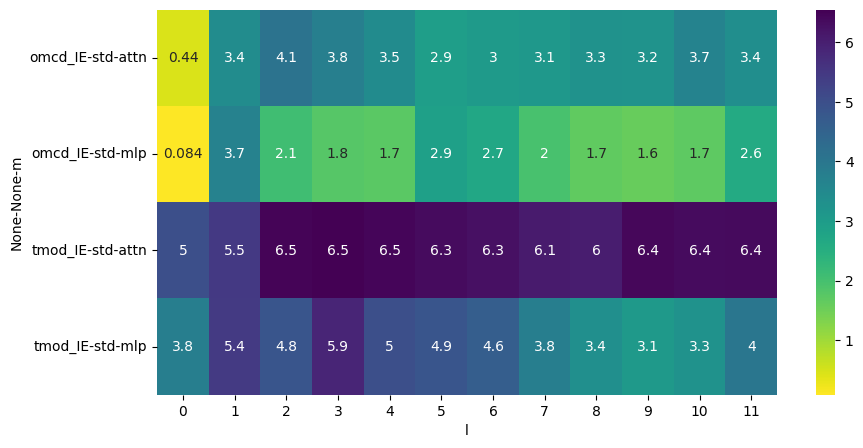

In [33]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    pd.concat(
        [df_omcd_ie.drop([("omcd_IE", "mean")], axis=1).unstack(-1).T, 
         df_tmod_ie.drop([("tmod_IE", "mean")], axis=1).unstack(-1).T],
        axis=0#, ignore_index=True
    ),
    cmap = 'viridis_r', annot=True
)

In [192]:
df_tmod_ie

tmod_IE          
             mean       std
l  m                       
0  attn  1.392550  4.755750
   mlp   1.239698  5.352454
1  attn  1.392361  5.056961
   mlp   1.347994  5.546974
2  attn  1.379095  5.367181
   mlp   0.969292  4.091656
3  attn  1.425283  5.418646
   mlp   1.328863  4.971496
4  attn  1.412697  5.753466
   mlp   1.275896  4.335904
5  attn  1.421866  5.498844
   mlp   1.208429  4.135693
6  attn  1.382109  5.340853
   mlp   1.141260  4.321564
7  attn  1.365664  5.306649
   mlp   0.992000  3.205233
8  attn  1.363969  5.716667
   mlp   0.890063  3.271982
9  attn  1.353166  5.365762
   mlp   0.906373  3.711678
10 attn  1.374312  5.537928
   mlp   0.756289  2.345117
11 attn  1.755053  6.847063
   mlp   1.213411  3.752539

In [193]:
df_omcd_ie

omcd_IE          
             mean       std
l  m                       
0  attn  0.000000  0.000000
   mlp   0.254446  0.880258
1  attn  1.509759  6.338639
   mlp   1.088170  5.017040
2  attn  0.805924  5.049498
   mlp   0.895984  3.699546
3  attn  0.806140  4.403909
   mlp   0.765413  7.922298
4  attn  0.861360  6.070074
   mlp   0.769589  2.782282
5  attn  0.820727  3.976727
   mlp   0.734714  3.754888
6  attn  0.802472  4.274798
   mlp   0.686684  2.627810
7  attn  0.850917  6.900412
   mlp   0.633919  1.725676
8  attn  0.907005  8.791721
   mlp   0.662103  2.859513
9  attn  0.874409  4.616572
   mlp   0.624362  3.218762
10 attn  0.948723  6.384575
   mlp   0.637038  5.260665
11 attn  0.897728  4.863683
   mlp   0.794367  4.932191

In [107]:
temp = load_dataset("machelreid/m2d2", "Religion_and_belief_systems__Major_beliefs_of_the_world", cache_dir=cache_dir)

Found cached dataset m2d2 (/rds/general/user/jj1122/ephemeral/.cache/huggingface/machelreid___m2d2/Religion_and_belief_systems__Major_beliefs_of_the_world/0.0.0/eb235f33a5de3163c10549b7f63c906910539c8a8c0ec5ade1285ccbf5067d00)
100%|██████████| 3/3 [00:00<00:00,  4.23it/s]


In [108]:
temp

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 492398
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 64074
    })
    test: Dataset({
        features: ['text'],
        num_rows: 64074
    })
})

# Model

## load models

In [23]:
base_model = GPT2LMHeadModel.from_pretrained("gpt2", cache_dir=cache_dir).to(device_id)
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(tuned_model_path)
tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

In [ ]:
# base_model = GPT2LMHeadModel.from_pretrained("gpt2").to(device_id)
# tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

In [ ]:
# diff_weights = {}
# for tuned_tup, base_tup in zip(list(tuned_model.named_parameters()), list(base_model.named_parameters())):
#     diff_weights[tuned_tup[0]] = torch.abs(tuned_tup[1] - base_tup[1]).mean().item()
    
# diff_weights

# Data

In [22]:
dataset = load_dataset("machelreid/m2d2", dataset_nm, cache_dir=cache_dir)

Found cached dataset m2d2 (/rds/general/user/jj1122/ephemeral/.cache/huggingface/machelreid___m2d2/Religion_and_belief_systems/0.0.0/eb235f33a5de3163c10549b7f63c906910539c8a8c0ec5ade1285ccbf5067d00)
100%|██████████| 3/3 [00:00<00:00, 229.65it/s]


In [ ]:
# np.random.seed(718)

# x = 10 * np.random.randint(100000)

# dataset['train']['text'][x:x+10]

In [ ]:
# # input_text = "He was a religious scholar and a prolific writer. Many of his works are used as references for church members"

# # input_text = "In popular and media culture, Anubis is often falsely portrayed as the sinister god of the dead"

# # input_text = "Ankou appears as a man or skeleton wearing a black robe and a large hat which conceals his face, or, on occasion, simply as a shadow"

# # input_text = "Zechariah's vision of recently deceased Joshua the High Priest depicts a dispute in the heavenly throne room between Satan and the Angel of the Lord"

# input_text = "The Transcendental Argument for the Existence of God (TAG) is the argument that attempts to prove the existence of God by arguing that logic, morals, and science ultimately presuppose a supreme being and that God must therefore be the source of logic and morals"


In [24]:
list_test_data = [x for x in dataset['test']['text'].copy() if x!=''] 

In [25]:
def load_model():
    return GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

In [26]:
def save_clean_activation(m_id):
    def save_clean_activation_hook(module, _input, _output):
#         print(m_id, _output.shape)
        if m_id.endswith('attn'):
            clean_activations[m_id] = _output[0].detach()
        elif m_id.endswith('mlp'):
#         else:
            clean_activations[m_id] = _output.detach()
    return save_clean_activation_hook


def corrupt_input_vector(module, _input):#, _output):
    torch.manual_seed(718)
    std = torch.std(_input[0])
    return tuple([_input[0] + (std*1.5) * torch.randn(_input[0].shape).to(device_id), ])

def restore_activation(m_id):
    def restore_activation_hook(module, _input, _output):
        clean_activation = clean_activations[m_id]#[:, t]
        if m_id.endswith('attn'):
#             corrupted_activation = _output[0].detach()
#             base_output[:, t] = tuned_output
#             corrupted_activation = clean_activation
            return tuple([clean_activation, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):           
            base_output = _output.detach()
#             base_output[:, t] = tuned_output
            base_output = clean_activation
            return base_output
    return restore_activation_hook

In [ ]:
def restore_activation(m_id):
    def restore_activation_hook(module, _input, _output):
        clean_activation = clean_activations[m_id]
        if m_id.endswith('attn'):
            return tuple([clean_activation, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):           
            base_output = _output.detach()
            base_output = clean_activation
            return base_output
    return restore_activation_hook

In [27]:
def corrupt_input_vector(module, _input):#, _output):
    torch.manual_seed(718)
    std = torch.std(_input[0])
    return tuple([_input[0] + (std*1.5) * torch.randn(_input[0].shape).to(device_id), ])

In [28]:
def restore_activation(m_id):
    def restore_activation_hook(module, _input, _output):
        clean_activation = clean_activations[m_id]#[:, t]
        if m_id.endswith('attn'):
#             corrupted_activation = _output[0].detach()
#             base_output[:, t] = tuned_output
#             corrupted_activation = clean_activation
            return tuple([clean_activation, tuple([_output[1][0], _output[1][1]])])
        elif m_id.endswith('mlp'):           
            base_output = _output.detach()
#             base_output[:, t] = tuned_output
            base_output = clean_activation
            return base_output
    return restore_activation_hook

## 10:45

In [30]:
list_results = [{} for x in range(len(list_test_data)) if x != ""]

for input_idx, input_text in enumerate(list_test_data):
    
    if input_idx % 1000 == 0:
        print(f"input_idx: {input_idx}")
    
    inputs = gpt2_tokenizer(input_text, return_tensors="pt").to(device_id)
    n_tokens = inputs['input_ids'].shape[1]
    
    list_input_text = gpt2_tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu().numpy())

    for idx in range(1, n_tokens):
        if not list_input_text[idx].startswith("Ġ"):
            list_input_text[idx-1] = list_input_text[idx-1] + "##"
        list_input_text[idx] = list_input_text[idx].replace("Ġ", "")
        
    # First run: clean run
    clean_activations = {}
    tuned_model = load_model()
    for m_id in list_trace_module_ids:
        tuned_model.get_submodule(m_id).register_forward_hook(save_clean_activation(m_id))
        
    with torch.no_grad():
        tuned_model.eval()
        clean_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)    
        clean_loss = np.exp(clean_outputs.loss.item())
    
    # Second run: corrupted run    
    tuned_model = load_model()
    tuned_model.get_submodule("transformer.h.0.attn").register_forward_pre_hook(corrupt_input_vector)    
    with torch.no_grad():
        torch.manual_seed(718)
        set_seed(718)
        tuned_model.eval()
        corrupted_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
        corrupted_loss = np.exp(corrupted_outputs.loss.item())
        
    corrupted_loss    

    # Third run: corrupted-with-restoration run    
    restored_loss = {}
    tuned_model = GPT2LMHeadModel.from_pretrained(tuned_model_path).to(device_id)

    with torch.no_grad():
        tuned_model.eval()
        tuned_model.get_submodule("transformer.h.0.attn").register_forward_pre_hook(corrupt_input_vector)
        for m_id in list_trace_module_ids:
            hook = tuned_model.get_submodule(m_id).register_forward_hook(restore_activation(m_id))
            restored_outputs = tuned_model(**inputs, labels=inputs.input_ids, output_hidden_states=True)
            restored_loss[m_id] = np.exp(restored_outputs.loss.item())
            hook.remove()
            
    list_results[input_idx]['clean_loss'] = clean_loss
    list_results[input_idx]['corrupted_loss'] = corrupted_loss
    list_results[input_idx]['restored_loss'] = restored_loss

input_idx: 0
input_idx: 1000
input_idx: 2000
input_idx: 3000


KeyboardInterrupt: 

In [32]:
import pickle as pkl
with open('230607_run_outputs.pkl', 'wb') as pkl_file:
    pkl.dump(list_results, pkl_file)

In [34]:
for i, d in enumerate(list_results):
    if len(d) == 0:
        print(i)
        break

3040


In [36]:
list_results_temp = list_results[:3000]

# Main

## first run - clean

### register hook - save_clean_activation

### get clean_activations & clean_loss

13.573352837326823

## second run - corruped

### register hook - corrupt_input_vector

### get corrupt_input_vector & corrupted_loss

18.395775714257592

## Thrid run - corrupted-with-restoration run

### register hook - restore_activation & restored losses

In [643]:
list(restored_loss.items())[:10]

[('transformer.h.0.attn', 13.573352837326823),
 ('transformer.h.0.mlp', 14.274880534457854),
 ('transformer.h.1.attn', 21.543103091989984),
 ('transformer.h.1.mlp', 20.8595076933879),
 ('transformer.h.2.attn', 17.51346675330437),
 ('transformer.h.2.mlp', 18.091306491554267),
 ('transformer.h.3.attn', 16.443810897114936),
 ('transformer.h.3.mlp', 16.982345444060076),
 ('transformer.h.4.attn', 17.352509155673943),
 ('transformer.h.4.mlp', 18.33990111156065)]

## Losses

In [37]:
list_results_temp[0]

{'clean_loss': 63.91878399603464,
 'corrupted_loss': 132.82606231021126,
 'restored_loss': {'transformer.h.0.attn': 63.91878399603464,
  'transformer.h.0.mlp': 72.45914462107228,
  'transformer.h.1.attn': 108.48300584563944,
  'transformer.h.1.mlp': 98.26031753662475,
  'transformer.h.2.attn': 105.73504141607684,
  'transformer.h.2.mlp': 157.61139900333075,
  'transformer.h.3.attn': 114.14795095597133,
  'transformer.h.3.mlp': 115.4669494255801,
  'transformer.h.4.attn': 100.84907069077829,
  'transformer.h.4.mlp': 95.89280867821321,
  'transformer.h.5.attn': 131.30313272151864,
  'transformer.h.5.mlp': 97.53559238094321,
  'transformer.h.6.attn': 102.20920983898758,
  'transformer.h.6.mlp': 109.59817642652683,
  'transformer.h.7.attn': 106.16284752779694,
  'transformer.h.7.mlp': 95.22004636798862,
  'transformer.h.8.attn': 112.71103032371055,
  'transformer.h.8.mlp': 108.70722262992827,
  'transformer.h.9.attn': 127.16515070581757,
  'transformer.h.9.mlp': 84.2516244105539,
  'transf

In [53]:
def parse_code(row):
    list_code = row.code.split(".")
    row['l'] = int(list_code[2])
    row['m'] = list_code[3]
#     row['t'] = int(list_code[4])
    return row

list_df_ide_temp = []
for i, d in enumerate(list_results_temp):
    df_t = pd.DataFrame.from_dict(d['restored_loss'], orient='index')
    TE = (corrupted_loss - clean_loss) / clean_loss
    IDE = {}
    for m_id in list_trace_module_ids:
        IDE[m_id] = (restored_loss[m_id] - clean_loss) / clean_loss
    
    df_ide = pd.DataFrame.from_dict(IDE, orient='index').reset_index()
    df_ide.columns = ['code', 'ide']
    df_ide = df_ide.apply(lambda row: parse_code(row), axis=1)
    df_ide["seq"] = i
    list_df_ide_temp.append(df_ide)
    break

In [644]:
clean_loss, corrupted_loss, np.mean(list(restored_loss.values()))

(13.573352837326823, 18.395775714257592, 17.73122174651327)

In [645]:
# TE = (base_loss - tuned_loss) / base_loss
# IDE = {}
# for m_id in list_trace_module_ids:
#     for t in range(n_tokens):
#         IDE[m_id + f'.{t}'] = restored_loss[m_id + f'.{t}'] / base_loss
        
TE = (corrupted_loss - clean_loss) / clean_loss
IDE = {}
for m_id in list_trace_module_ids:
    IDE[m_id] = (restored_loss[m_id] - clean_loss) / clean_loss

In [646]:


df_ide = pd.DataFrame.from_dict(IDE, orient='index').reset_index()
df_ide.columns = ['code', 'ide']
df_ide = df_ide.apply(lambda row: parse_code(row), axis=1)
# df_ide['token'] = df_ide['t'].apply(lambda x: list_input_text[int(x)])

## Results

##### He was a religious scholar and a prolific writer. Many of his works are used as references for church members

<Axes: xlabel='None-l', ylabel='m'>

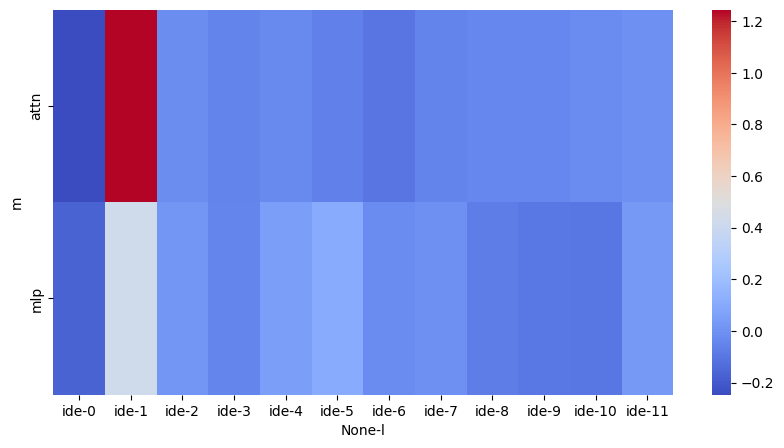

In [58]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code', 'seq'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=0.3, vmin=0, vmax=1.2, vmin=0.8
)

##### 'In popular and media culture, Anubis is often falsely portrayed as the sinister god of the dead'


<Axes: xlabel='None-l', ylabel='m'>

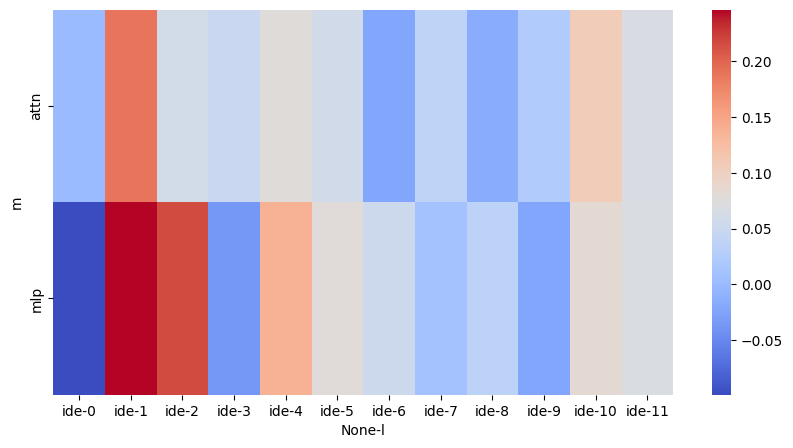

In [599]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### Elderly people often have limited regenerative abilities and are more susceptible to disease, syndromes, injuries and sickness than younger adults.

<Axes: xlabel='None-l', ylabel='m'>

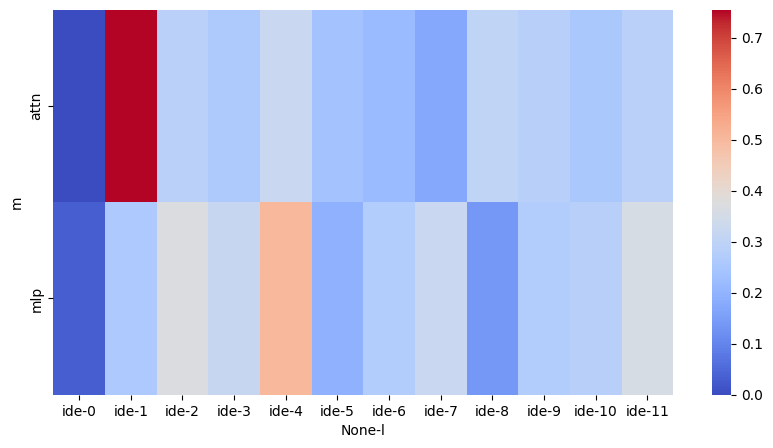

In [615]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### "Zechariah's vision of recently deceased Joshua the High Priest depicts a dispute in the heavenly throne room between Satan and the Angel of the Lord"


<Axes: xlabel='None-l', ylabel='m'>

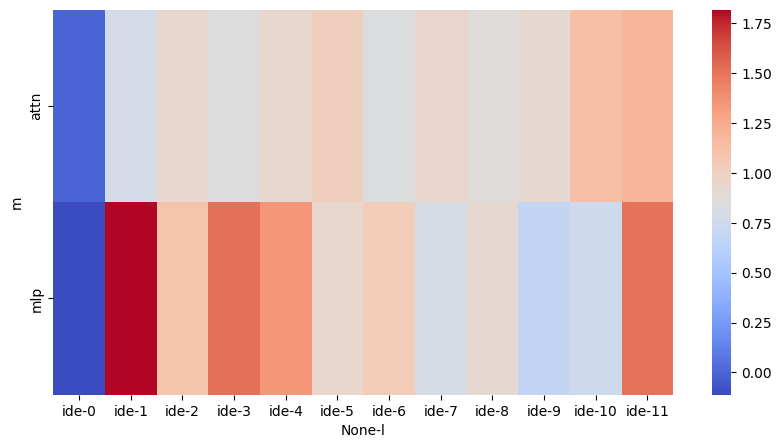

In [631]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

##### The Transcendental Argument for the Existence of God (TAG) is the argument that attempts to prove the existence of God by arguing that logic, morals, and science ultimately presuppose a supreme being and that God must therefore be the source of logic and morals

<Axes: xlabel='None-l', ylabel='m'>

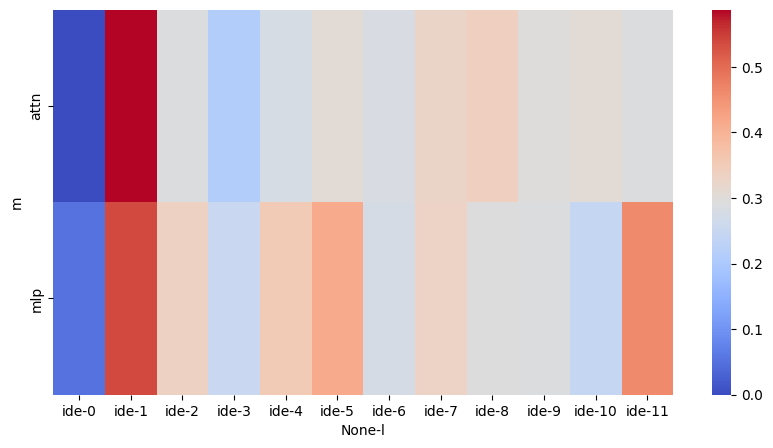

In [647]:
plt.rcParams["figure.figsize"] = (10,5)

sns.heatmap(
    df_ide.drop(['code'], axis=1).set_index(['m', 'l']).unstack(-1),
    cmap='coolwarm'#, vmax=1.2, vmin=0.8
)

## Conclusion
Couldn't find a specific pattern.  
I will extend this approach, using the entire dataset and aggregating IDE values.